In [1]:
import numpy as np

In [2]:
from TFANN import ANNR
import matplotlib.pyplot as mpl
from sklearn.preprocessing import scale

In [3]:
class PastSampler:
    '''
    Forms training samples for predicting future values from past value
    '''

    def __init__(self, N, K):
        '''
        Predict K future sample using N previous samples
        '''
        self.K = K
        self.N = N

    def transform(self, A, Y = None):
        M = self.N + self.K     #Number of samples per row (sample + target)
        #Matrix of sample indices like: {{1, 2..., M}, {2, 3, ..., M + 1}}
        I = np.arange(M) + np.arange(A.shape[0] - M + 1).reshape(-1, 1)
        B = A[I].reshape(-1, M * A.shape[1], *A.shape[2:])
        ci = self.N * A.shape[1]    #Number of features per sample
        return B[:, :ci], B[:, ci:] #Sample matrix, Target matrix


In [4]:
import numpy as np
import os
import pandas as pd
import urllib.request
     
def GetAPIUrl(cur, sts = 1420070400):
    '''
    Makes a URL for querying historical prices of a cyrpto from Poloniex
    cur:    3 letter abbreviation for cryptocurrency (BTC, LTC, etc)
    '''
    return 'https://poloniex.com/public?command=returnChartData&currencyPair=USDT_{:s}&start={:d}&end=9999999999&period=7200'.format(cur, sts)
 
def GetCurDF(cur, fp):
    '''
    cur:    3 letter abbreviation for cryptocurrency (BTC, LTC, etc)
    fp:     File path (to save price data to CSV)
    '''
    openUrl = urllib.request.urlopen(GetAPIUrl(cur))
    r = openUrl.read()
    openUrl.close()
    df = pd.read_json(r.decode())
    df['date'] = df['date'].astype(np.int64) // 1000000000  ## datetime.fromtimestamp(1424138400) to convert back
    return df
 
#%%Path to store cached currency data
datPath = 'CurDat/'
if not os.path.exists(datPath):
    os.mkdir(datPath)
#Different cryptocurrency types
cl = ['BTC', 'LTC', 'ETH', 'XMR', 'XRP']
#Columns of price data to use
CN = ['close', 'high', 'low', 'open', 'volume']
#Store data frames for each of above types
D = []
for ci in cl:
    dfp = os.path.join(datPath, ci + '.csv')
    try:
        df = pd.read_csv(dfp, sep = ',')
    except FileNotFoundError:
        df = GetCurDF(ci, dfp)    
    D.append(df)

In [5]:
for i in range(0,len(D)):
    D[i] = D[i].merge(D[-1][['date','open','close']].rename(columns = ({'open':'XRP_Open', 'close':'XRP_Close'})), on='date', how='right')
    D[i] = D[i].fillna(0)

#%%Only keep range of data that is common to all currency types

In [7]:
CN_2 = CN

In [8]:
CN_2.extend(['XRP_Open','XRP_Close'])

In [9]:
CN = CN_2

In [10]:
 #%%Features are channels
C = np.hstack((Di[CN] for Di in D))[:, None, :]  ## CN_2 selecting all the features
HP = 16                 #Holdout period
A = C[0:-HP]                
SV = A.mean(axis = 0)   #Scale vector
C /= SV                 #Basic scaling of data
#%%Make samples of temporal sequences of pricing data (channel)
NPS, NFS = 256, 16         #Number of past and future samples
ps = PastSampler(NPS, NFS)
B, Y = ps.transform(A)

c:\users\zhen\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [11]:
from TFANN import ANNR
 
NC = B.shape[2]
#2 1-D conv layers with relu followed by 1-d conv output layer
ns = [('C1d', [8, NC, NC * 2], 4), ('AF', 'relu'), 
      ('C1d', [8, NC * 2, NC * 2], 2), ('AF', 'relu'), 
      ('C1d', [8, NC * 2, NC], 2)]
#Create the neural network in TensorFlow
cnnr = ANNR(B[0].shape, ns, batchSize = 32, learnRate = 2e-5, 
            maxIter = 64, reg = 1e-5, tol = 1e-2, verbose = True)
cnnr.fit(B, Y)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Iter     1	      1.93252961 (Batch Size:    32)
Iter     2	      1.33265961 (Batch Size:    32)
Iter     3	      1.29271963 (Batch Size:    32)
Iter     4	      1.16041841 (Batch Size:    32)
Iter     5	      1.17634431 (Batch Size:    32)
Iter     6	      1.08505598 (Batch Size:    32)
Iter     7	      1.09703301 (Batch Size:    32)
Iter     8	      1.05774127 (Batch Size:    32)
Iter     9	      1.08626713 (Batch Size:    32)
Iter    10	      1.09095064 (Batch Size:    32)
Iter    11	      1.08351047 (Batch Size:    32)
Iter    12	      1.05125307 (Batch Size:    32)
Iter    13	      1.02017002 (Batch Size:    32)
Iter    14	      1.07538457 (Batch Size:    32)
Iter    15	      1.0

In [12]:
PTS = []                        #Predicted time sequences
P, YH = B[[-1]], Y[[-1]]        #Most recent time sequence
for i in range(HP // NFS):  #Repeat prediction
    P = np.concatenate([P[:, NFS:], YH], axis = 1)
    YH = cnnr.predict(P)
    PTS.append(YH)
PTS = np.hstack(PTS).transpose((1, 0, 2))
A = np.vstack([A, PTS]) #Combine predictions with original data
A = np.squeeze(A) * SV  #Remove unittime dimension and rescale
C = np.squeeze(C) * SV

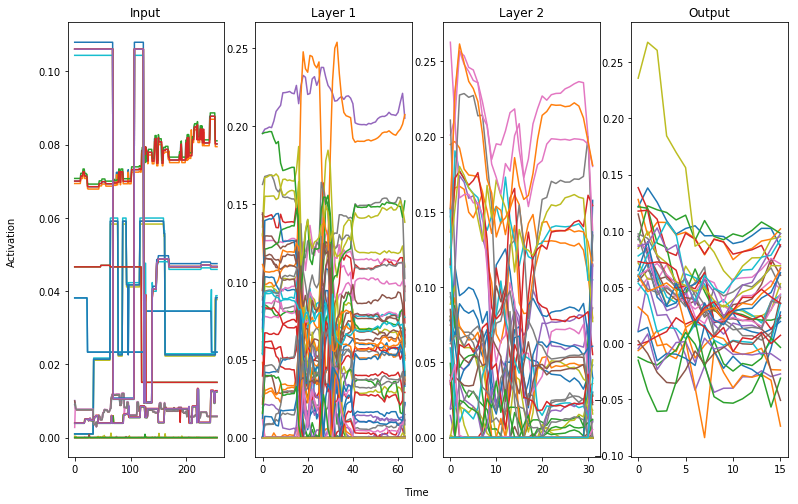

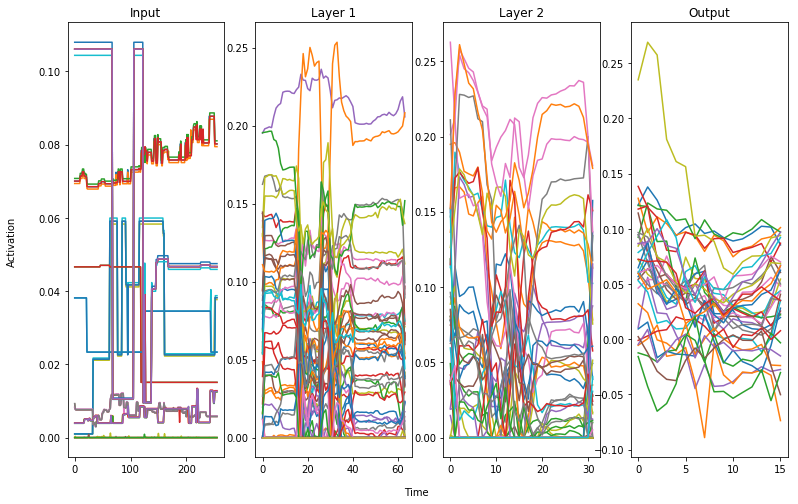

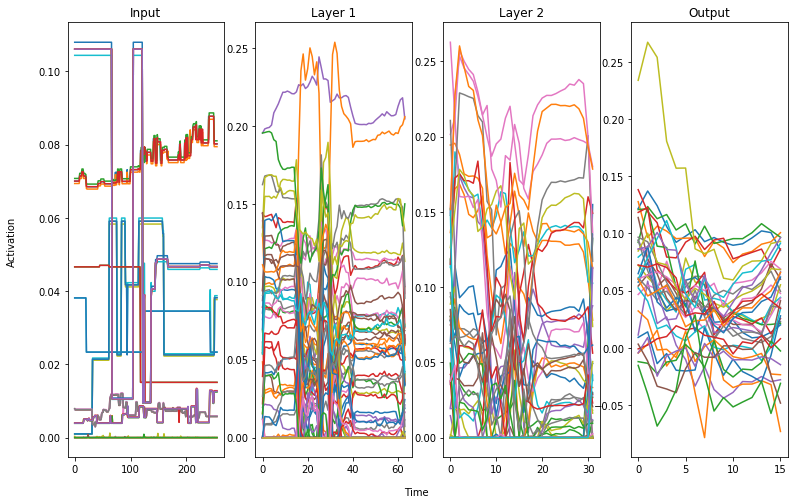

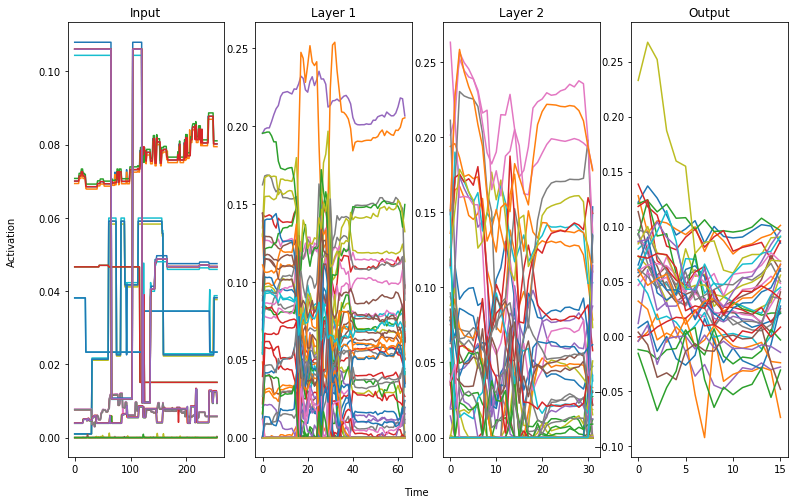

In [13]:
import matplotlib.pyplot as mpl
 
nt = 4
PF = cnnr.PredictFull(B[:nt])
for i in range(nt):
    fig, ax = mpl.subplots(1, 4, figsize = (16 / 1.24, 10 / 1.25))
    ax[0].plot(PF[0][i])
    ax[0].set_title('Input')
    ax[1].plot(PF[2][i])
    ax[1].set_title('Layer 1')
    ax[2].plot(PF[4][i])
    ax[2].set_title('Layer 2')
    ax[3].plot(PF[5][i])
    ax[3].set_title('Output')
    fig.text(0.5, 0.06, 'Time', ha='center')
    fig.text(0.06, 0.5, 'Activation', va='center', rotation='vertical')
    mpl.show()

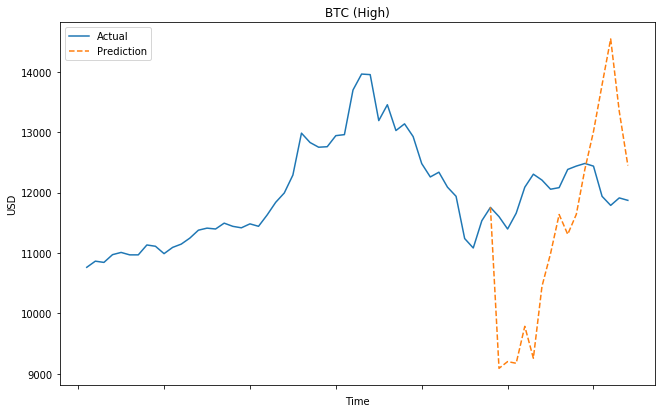

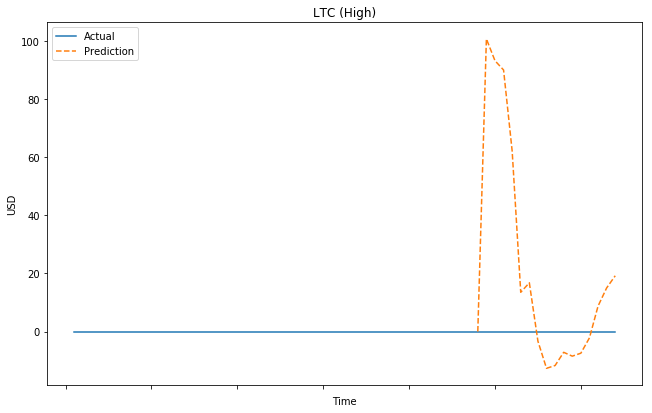

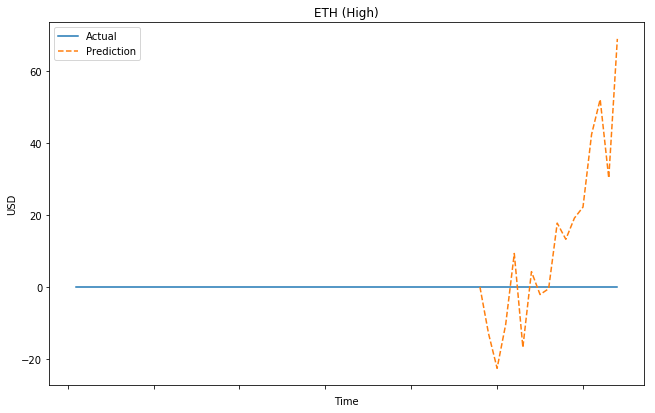

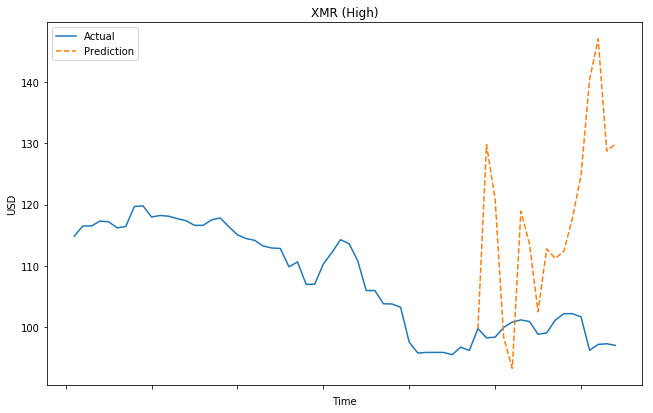

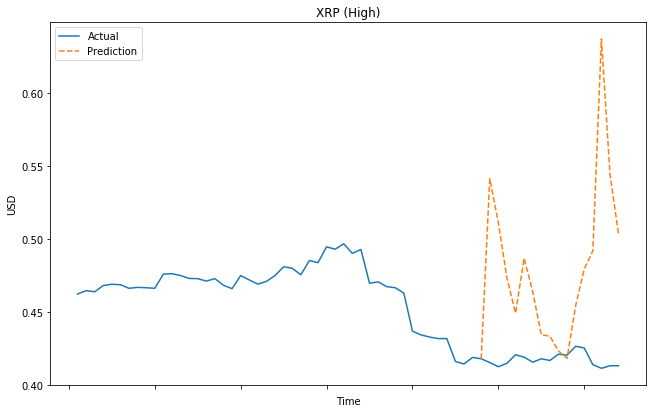

In [14]:
CI = list(range(C.shape[0]))
AI = list(range(C.shape[0] + PTS.shape[0] - HP))
NDP = PTS.shape[0] #Number of days predicted
for i, cli in enumerate(cl):
    fig, ax = mpl.subplots(figsize = (16 / 1.5, 10 / 1.5))
    hind = i * len(CN) + CN.index('high')
    ax.plot(CI[-4 * HP:], C[-4 * HP:, hind], label = 'Actual')
    ax.plot(AI[-(NDP + 1):], A[-(NDP + 1):, hind], '--', label = 'Prediction')
    ax.legend(loc = 'upper left')
    ax.set_title(cli + ' (High)')
    ax.set_ylabel('USD')
    ax.set_xlabel('Time')
    ax.axes.xaxis.set_ticklabels([])
    mpl.show()